In [157]:
import gym 
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Linear, ReLU 
import torch.nn.functional as F
from torch.autograd import Variable

This Jupyternotebook will run a plain REINFORCE algorithm 
on Cartpole Problem.

REINFORCE Algorithm:

$\nabla J(\theta) = \mathbb{E}[\sum_{t = 0}^\infty \sum^\infty_{t=0} r_t \nabla_\theta \log \pi_\theta(a_t|s_t)]$

That's how we will build our loss function. (See parts annotated by loss) 

The rest is simple, build a network and tune. 

In [158]:
class REINFORCE(torch.nn.Module):
    def __init__(self):
        super(REINFORCE,self).__init__()
        self.fc1 = Linear(4, 24)
        self.fc2 = Linear(24, 48)
        self.fc3 = Linear(48, 24)
        self.fc4 = Linear(24, 2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

In [159]:
env = gym.make('CartPole-v0')
obs = env.reset()
model = REINFORCE()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
gamma = 0.99
steps = []
for episode in range(100000):
    obs_list = []
    log_prob = []
    for step in range(200):
        obs_list.append(obs)
        obs = np.reshape(obs, [1,-1])
        obs = Variable(torch.from_numpy(obs).float())
        action_probability = model(obs)
        with torch.no_grad():
            action = np.random.choice(2, p=torch.exp(action_probability)[0].detach().numpy())
        log_prob.append(action_probability[0][action])
        obs, reward, done, info = env.step(action)
        if done:
            steps.append(step)
            print(f'episode {episode}, step {step}', end = '\r')
            reward_list = np.ones((step + 1,))
            for i in range(len(reward_list)-2, -1, -1):
                reward_list[i] += reward_list[i+1] * gamma
            reward_list -= np.mean(reward_list)
            reward_list /= np.std(reward_list)
            # ------calculate loss start------
            loss = 0
            # We are computing Log(pi) and sum it together here.
            # Note the loss is negative. Since we need gradient Ascent.
            for a, b in zip(log_prob, reward_list):
                loss -= a*b
            # ------calculate loss end------
            model.zero_grad()
            loss.backward()
            optimizer.step()
            obs = env.reset()
            break
    if np.mean(steps[-20:]) > 180:
        break   

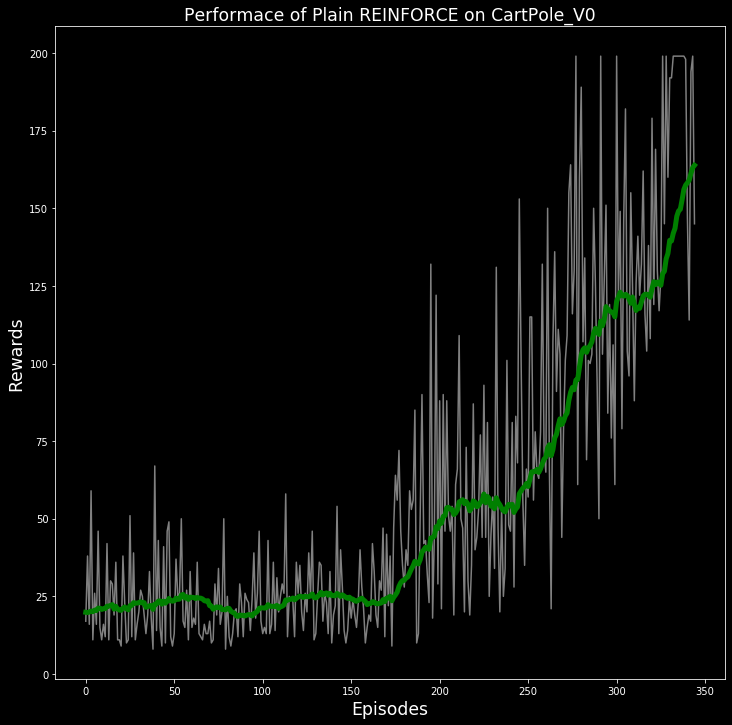

In [160]:
mid = []
interval = 30
plt.style.use('dark_background')
for i in range(len(steps) - interval):
    mid.append(np.mean(steps[i:i+interval+1]))
plt.figure(figsize=(12,12))
plt.title('Performace of Plain REINFORCE on CartPole_V0',fontsize = 'xx-large')
plt.xlabel('Episodes', fontsize = 'xx-large')
plt.ylabel('Rewards',fontsize = 'xx-large')
x_fit = list(range(len(steps) - interval))
plt.plot(x_fit, steps[interval:], '-', c = 'gray') 
plt.plot(mid, '-', c= 'green', linewidth = 5)
plt.show()